In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 7.0)

import re
import warnings
from numba import NumbaPendingDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)
import nltk

from utils import utils, cyk, data_process, oov

## Build grammar and OOV module

In [2]:
train_path = 'sequoia-corpus+fct.mrg_strict'
train_start = 0
train_end = 0.8

### Get training data

In [3]:
train_vocabulary, train_grammar_rules, train_rhs_index, train_prob_lexicon = data_process.get_train_data(train_path, train_start, train_end)

Loading data...
Generating trees...
Get train vocabulary... 

  3%|▎         | 80/2479 [00:00<00:03, 687.49it/s]

8958 words
Separate grammar from lexical rules...


100%|██████████| 2479/2479 [00:01<00:00, 1648.73it/s]


Get probabilistic lexicon... 10528 triplets (token, tag, prob)
Get grammar pcfg... 4052 productions
Done


### Get French word embeddings

In [4]:
embedding_path = 'polyglot-fr.pkl'

In [5]:
fr_words, embeddings, word_id, id_word = utils.get_embeddings(embedding_path)

# Normalize digits by replacing them with #
DIGITS = re.compile("[0-9]", re.UNICODE)

# considered transformations when looking for in vocabulary words
TRANSFOS = [lambda w: DIGITS.sub("#", w), lambda w: w.lower(), lambda w: w.upper(), lambda w: w.title()]

train_embeddings, train_word_id, voc_id_word = utils.process_embeddings(word_embeddings=embeddings, word_id_dic=word_id,
                                                                  vocabulary=train_vocabulary,
                                                                  re_rules=[lambda s: DIGITS.sub("#", s)])

print("Vocabulary-specific embedding shape is {}".format(train_embeddings.shape))

Emebddings shape is (100004, 64)
Vocabulary-specific embedding shape is (7427, 64)


### Get test data for prediction

In [8]:
test_path = 'test_file.txt'
test_start, test_end = 0, 1

In [9]:
test_sentences = data_process.get_to_predict_data(test_path, test_start, test_end)

## Get parsing predictions

### Define an OOV handler function

In [10]:
def oov_handler(word):
    return oov.oov(word, train_vocabulary,
               fr_words, all_embs=embeddings, all_word_id_dic=word_id, voc_embs=train_embeddings,
               voc_id_word_dic=voc_id_word,
               transformations=TRANSFOS,
               k=2)

In [11]:
beam = 10 

parsed_str, parsed = utils.predict(test_sentences, train_grammar_rules, train_prob_lexicon, train_rhs_index,
                                     oov_handler,
                                     p_output=True, beam=beam, chrono=True)

0it [00:00, ?it/s]

(SENT (PP (P À) (NP (DET la) (NC recherche) (VPpart (NP (DET du) (NC temps)) (VPP perdu)))) (PONCT .))


2it [00:07,  3.58s/it]

(SENT (NP (DET le) (NC silence) (ADJ éternel)) (PP (P de) (NP (DET ces) (NC espaces) (ADJ infinis))) (VN (CLR m') (V effraie)) (PONCT .))


3it [00:08,  2.73s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Ce) (NP (PROREL qui)) (ADV ne) (CLS nous) (AP (ADJ tue)) (ADV pas) (CLS nous) (V rend) (ADV plus) (AP (ADJ forts)) (PONCT ?))
Parsed 3 sentences
. - Total parsing: 66.67% 
  - Mean time to handle oov: 2.73s
  - Mean time to build membership table: 0.01s


['le', 'silence', 'éternel', 'de', 'ces', 'espaces', 'infinis', "m'", 'effraie', '.']
( (SENT (NP (DET le) (NC silence) (ADJ éternel)) (PP (P de) (NP (DET ces) (NC espaces) (ADJ infinis))) (VN (CLR m') (V effraie)) (PONCT .)))



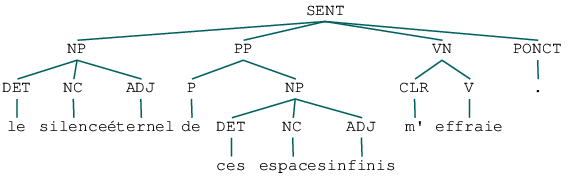

In [28]:
i = 1
print(test_sentences[i])
print(parsed_str[i])
nltk.tree.Tree.fromstring(parsed_str[i])[0]

### Save predictions

In [30]:
output_path = 'test_output.txt'

In [32]:
print("Write predictions in %s..." % output_path, end=' ')
utils.write_in_file(output_path, parsed_str)
print('Done')

Write predictions in test_output.txt... Done


## Get parsing evaluation from labeled data

In [33]:
test_path = 'sequoia-corpus+fct.mrg_strict'
test_start=0.9
test_end = 1

In [34]:
test_sentences, test_labels = data_process.get_to_eval_data(test_path, test_start, test_end)

Loading data...
Generating trees...
Generate validation and test datasets...


In [ ]:
parsed_str, score, parsed = utils.evaluate(test_sentences, test_labels, 
                                     train_grammar_rules, train_prob_lexicon, train_rhs_index, 
                                     oov_handler, p_output=True, 
                                     beam=beam, chrono=True)

1it [00:06,  6.30s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (ADJ 19) (NC janvier) (NC 2004) (PONCT :) (DET le) (NC juge) (ADJ Armand) (ADJ Riberolles) (NC clôt) (DET ses) (NC investigations) (CC et) (DET l') (NC instruction) (P de) (DET l') (NC affaire) (P+D des) (NC HLM) (P de) (NP (NPP Paris)) (PONCT .))


2it [00:14,  6.73s/it]

(SENT (PONCT -) (NP (NC Février) (NC 2005)) (PONCT :) (NP (DET le) (NC parquet) (PP (P de) (NP (NPP Paris)))) (VN (V requiert)) (NP (DET un) (NC non-) (NC lieu)) (PP (P en_faveur_de) (NP (NPP Jean) (NPP Tiberi))) (PONCT ,) (VPpart (VPP accordé) (PP (P par) (NP (DET le) (NC juge))) (NP (ADJ Armand) (NC Riberolles))) (PONCT .))


3it [00:15,  5.08s/it]

(SENT (VN (CLS Il) (V demande)) (ADV toutefois) (NP (DET le) (NC renvoi) (PP (P devant) (NP (DET le) (NC tribunal) (AP (ADJ correctionnel))))) (PP (P de) (NP (DET la) (NC majorité))) (PP (P de) (NP (DET la) (NC cinquantaine))) (PP (P de) (NP (NC personnes) (VPpart (VPP mises) (PP (P en) (NP (NC examen)))))) (PONCT .))


4it [00:56, 15.91s/it]

(SENT (PONCT -) (NP (NC Juin) (NC 2005)) (PONCT :) (NP (DET l') (PREF ex-) (NC conseiller)) (NP (NC général) (NP (NC RPR) (PP (P+D des) (NP (NPP Hauts-de-Seine))) (NPP Didier) (NPP Schuller))) (COORD (CC et) (NP (DET le) (NC député-maire))) (PONCT -LRB-) (NP (NPP UMP) (PONCT -RRB-) (Srel (PP (P de) (NP (NPP Levallois-Perret))) (NP (NPP Patrick) (NPP Balkany)) (VN (V comparaissent)) (PP (P devant) (NP (DET le) (NC tribunal) (AP (ADJ correctionnel)))) (PP (P de) (NP (NPP Créteil))) (PP (P dans) (NP (DET l') (NC affaire))) (NP (DET des) (NC HLM)) (PP (P+D des) (NP (NPP Hauts-de-Seine))))) (PONCT .))
/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NP (NC Procès)) (P en) (ADJ première) (NC instance))


6it [00:57, 11.32s/it]

(SENT (PONCT -) (NP (DET Le) (NC procès) (PP (P de) (NP (DET l') (NC affaire)))) (NP (DET des) (NC HLM) (PP (P de) (NP (NPP Paris)))) (VN (CLR s') (V est) (VPP déroulé)) (PP (P dans) (NP (DET l') (NC indifférence))) (PP (P+D du) (NP (DET 23) (NC décembre) (NC 2005))) (PP (P+D au) (NP (DET 5) (NC avril) (NC 2006))) (PONCT .))


7it [01:03,  9.73s/it]

(SENT (PONCT -) (NP (DET Les) (NC hommes) (AP (ADJ politiques))) (NP (NC -clés) (PP (P de) (DET la)) (AP (ADJ capitale)) (PP (P comme) (NP (NPP Jean) (NPP Tiberi)))) (PONCT ,) (NP (NPP Michel) (NPP Roussin) (COORD (CC ou) (NP (NPP Jacques) (NPP Chirac)))) (VN (V ont) (VPP bénéficié)) (PP (P de) (NP (NC non-) (NC lieu))) (PONCT ,) (NP (DET de) (NC vices)) (PP (P de) (NP (NC forme))) (COORD (CC ou) (PP (P de) (NP (NC protection) (AP (ADJ statutaire))))) (PONCT .))


8it [01:08,  8.19s/it]

(SENT (PP (P Selon) (NP (DET l') (NC accusation) (PONCT :)) (PONCT ")) (NP (DET L') (NC instruction) (ADV n')) (VN (V est)) (NP (NC pas) (VPpart (VPP parvenue) (VPinf (P à) (VN (VINF établir)) (ADV formellement) (NP (DET l') (NC implication) (AP (ADJ personnelle)) (NP (DET des) (NC responsables) (PP (P au_sein_de) (NP (DET l') (NC appareil) (AP (ADJ politique))))) (PP (P+D du) (NP (NPP RPR)))))) (PONCT .)) (PONCT "))


9it [01:19,  9.20s/it]

(SENT (PP (ADV -) (P En) (NP (DET l') (NC absence) (PP (P de) (NP (DET tout) (NC responsable) (AP (ADJ politique)))))) (PONCT ,) (VN (CLS c') (V est)) (NP (DET l') (ADJ ancien) (NC directeur) (AP (ADJ général)) (PP (P de) (NP (DET l') (NPP Office))) (NP (NC public) (NC HLM))) (PP (P de) (NP (NPP Paris))) (COORD (CC et) (NP (NC élu) (AP (ADJ corrézien)))) (PONCT ,) (NP (NPP Georges) (NPP Pérol) (PONCT ,) (Srel (NP (PROREL qui)) (VN (V fait)))) (VN (V figure)) (PP (P de) (NP (NC clé) (PP (P de) (NP (NC voûte))))) (PP (P de) (NP (DET ce) (ADJ vaste) (NC système) (PP (P de) (NP (NC versements) (PP (P de) (NP (NC commissions))) (PP (P par) (NP (DET les) (NC entreprises)))))) (COORD (CC et) (NP (DET de) (NC détournement)))) (PP (P de) (NP (NC procédures) (PP (P dans) (NP (DET l') (NC attribution))) (PP (P de) (NP (NC marchés) (ADJ publics))))) (PONCT .))


10it [01:23,  7.45s/it]

(SENT (PP (P Contre) (NP (PRO lui))) (PONCT ,) (NP (DET le) (NC parquet)) (VN (V a) (VPP requis)) (NP (DET quatre) (NC ans) (PP (P d') (NP (NC emprisonnement)))) (PP (P avec) (NP (NC sursis))) (PONCT ,) (NP (DET 50_000) (NC euros) (PP (P d') (NP (NC amende))) (COORD (CC et) (NP (DET trois) (NC ans) (PP (P d') (NP (NC interdiction) (PP (P+D des) (NP (NC droits) (AP (ADJ civiques))))) (COORD (CC et) (NP (NC civils))))))) (PONCT .))


11it [01:39, 10.15s/it]

(SENT (PONCT -) (NP (DET Le) (ADJ 14) (NC mars) (NC 2006)) (PONCT ,) (NP (DET des) (NC peines) (PP (P de) (NP (NC prison)))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (Sint (NP (DET des) (NC amendes)) (VN (V ont) (VPP été) (VPP requises)) (PP (P contre) (DET 41)) (PP (P+D des) (NP (DET 49) (NC prévenus) (PP (P+D du) (NP (NC procès) (PP (P de) (NP (DET l') (NC office) (AP (ADJ public)))) (NC HLM) (PP (P de) (NP (NPP Paris))))) (PONCT -LRB-) (NP (NC OPAC)) (PONCT -RRB-) (PONCT ,) (VPpart (VPP considérés) (PP (P comme) (NP (DET les) (NC acteurs))) (COORD (CC ou) (NP (DET les) (NC complices) (PP (P d') (NP (DET un) (PONCT ") (NC système))) (PP (P de) (NP (NC fraude) (PP (P de) (NP (ADJ grande) (NC envergure)))))))) (PONCT ,) (VPpart (ADV parfaitement) (VPP organisé) (PONCT ") (COORD (CC et) (VPpart (VPP destiné) (VPinf (P à) (PONCT ") (VN (VINF constituer)) (NP (DET des) (NC caisses) (NC noires)))))) (PONCT "))) (PONCT ,)))) (PP (P selon) (NP (DET les) (NC mots))) (PP (P de) (NP (DET la

12it [01:45,  8.99s/it]

(SENT (NP (NC Évoquant)) (NP (P dès) (DET le) (NC début)) (PP (P de) (NP (DET son) (NC réquisitoire))) (PONCT ,) (PP (P devant) (NP (DET la) (ADJ 11e) (NC chambre) (PP (P+D du) (NP (NC tribunal) (AP (ADJ correctionnel)))) (PP (P de) (NP (NPP Paris))))) (PONCT ,) (NP (DET la) (NC question)) (PP (P+D du) (NP (NC financement) (AP (ADJ politique)))) (PONCT ,) (VN (CLS elle) (V a)) (NP (NC relevé) (ADV que)) (PONCT ") (NP (DET l') (NC instruction)) (VN (ADV n') (V a) (ADV pas) (VPP trouvé)) (PP (P de) (NP (NC réponse))) (COORD (CC et) (VN (CLR s') (V est) (VPP heurtée)) (PP (P+D au) (NP (NC silence) (COORD (CC et) (PP (P+D aux) (NP (NC flux) (AP (ADJ financiers))))))) (PP (P+D des) (NP (NC sociétés) (NC off-shore)))) (PONCT ") (PONCT .))


13it [01:48,  7.20s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (DET 5) (NC avril) (NC 2006) (PONCT :) (AP (ADJ dernier)) (NC jour) (P+D du) (NC procès) (P+D des) (NC HLM) (P de) (NC paris) (VPP consacré) (P+D aux) (NC plaidoiries) (PONCT .))


14it [01:52,  6.14s/it]

(SENT (PP (P Pendant) (NP (DET deux) (NC mois) (COORD (CC et) (NP (NC demi)))) (NP (DET de) (NC débats))) (PONCT ,) (NP (DET une) (NC cinquantaine) (PP (P de) (NP (ADJ chefs) (DET d') (NC entreprise)))) (VN (V ont) (VPP été) (VPP entendus)) (COORD (CC et) (VN (V ont) (VPP reconnu)) (VPinf (VN (VINF avoir) (VPP versé)) (NP (DET des) (NC fonds) (PP (P contre) (NP (DET l') (NC obtention) (PP (P de) (NP (NC marchés) (NP (DET des) (NC HLM))))))) (PP (P de) (NP (NPP Paris))))) (PONCT .))


15it [01:53,  4.65s/it]

(SENT (NP (DET Aucun) (NC financement) (AP (ADJ politique)) (AP (ADJ occulte))) (VN (ADV n') (V a) (VPP pu)) (VPinf (VN (VINF être) (VPP mis)) (PP (P en) (NP (NC évidence)))) (PONCT .))


16it [02:12,  8.74s/it]

(SENT (NP (DET L') (NC utilisation)) (PP (P de) (NP (NC sociétés-écrans) (VPpart (VPP basées) (PP (P dans) (NP (DET des) (NC paradis) (AP (ADJ fiscaux))))))) (PONCT -LRB-) (VPinf (VN (VINF voir)) (NP (NC société) (AP (ADJ panaméenne)) (COORD (CC et) (AP (ADJ fiduciaire))) (AP (ADJ suisse)))) (PONCT -RRB-) (Sint (VN (V a) (VPP empêché)) (VPinf (P de) (VN (VINF retracer)) (NP (DET les) (NC flux) (AP (ADJ financiers))))) (PONCT .))


17it [02:13,  6.57s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Les) (NC marchés) (NP (NC truqués)))


18it [02:15,  5.09s/it]

(SENT (NP (DET Les) (NC ascenseurs) (NP (DET des) (NC HLM))) (PP (P de) (NP (NPP Paris))))


19it [02:24,  6.37s/it]

(SENT (PONCT -) (NP (DET Le) (NC contrat) (PP (P de) (NP (NC maintenance)))) (COORD (CC et) (Sint (NP (DET de) (NC rénovation) (PP (P+D des) (NP (DET 3_092) (NC cabines))) (PP (P d') (NP (NC ascenseurs) (NP (DET des) (NC immeubles) (PP (P d') (NP (NC HLM) (AP (ADJ parisiens)))))))) (VN (V est) (VPP attribué)) (PP (P en) (NP (NC 1992))))) (PONCT .))


20it [02:26,  5.14s/it]

(SENT (NP (DET Le) (NC marché)) (VN (V est)) (AP (ADJ important) (PONCT :) (NP (DET 2,2) (NC milliards) (PP (P de) (NP (NC francs))) (PP (P sur) (NP (DET quinze) (NC ans))) (PONCT ,) (COORD (CC soit) (NP (DET un) (NC budget) (AP (ADJ annuel)) (PP (P de) (NP (DET 140) (NC millions))))) (PP (P de) (NP (NC francs)))) (PONCT .)))


21it [02:37,  6.77s/it]

(SENT (PONCT -) (NP (DET Trois) (NC entreprises)) (VN (V sont)) (NP (NC retenues) (PONCT :) (NP (DET la) (NC Somatem) (NP (PONCT ,) (NC filiale) (VPinf (P de) (VN (CLO la) (V Lyonnaise)) (NP (DET des) (NC eaux)) (PONCT ,) (NP (DET la) (NPP CG2A)) (PONCT ,) (NP (NC filiale) (PP (P de) (NP (DET l') (PREF ex-) (NC Compagnie))) (AP (ADJ générale)) (VPpart (NP (DET des) (NC eaux) (PONCT -LRB-) (NP (NC CGE)) (PONCT ,)) (VPP devenue))))) (NPP Vivendi)) (PONCT -RRB-)) (PONCT ,) (COORD (CC et) (NP (DET le) (NC groupe) (AP (ADJ américain)) (NPP Otis))) (PONCT .))


22it [02:43,  6.41s/it]

/!\ PARTIAL PARSING /!\	(SENT (CC Otis) (VN (V refuse)) (P de) (VN (VINF traiter)) (P avec) (NPP Jean-Claude) (NC Méry) (CC et) (VN (VINF obtiendra)) (DET un) (ADJ petit) (NC lot) (P en) (VPP rémunérant) (DET un) (ADJ autre) (NC intermédiaire) (PONCT .))


23it [02:48,  6.06s/it]

(SENT (PONCT -) (NP (DET L') (NC enquête)) (VN (V a) (VPP montré)) (ADV que) (PONCT ,) (PP (P pour) (NP (DET cet) (NC appel))) (PP (P d') (NP (NC offres))) (PONCT ,) (NP (DET des) (NC commissions)) (VN (V avaient) (VPP été) (VPP versées)) (PP (PONCT ,) (P via) (NP (DET le) (NC règlement) (PP (P de) (NP (NC factures))))) (PP (P d') (NP (PONCT ") (NC assistance) (AP (ADJ commerciale)) (PONCT ") (PP (P à) (NP (NP (DET l') (PRO une)) (DET des) (NC sociétés)))) (PP (P de) (NP (NPP Jean-Claude) (NPP Méry)))) (PONCT .))


24it [02:56,  6.63s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Un) (NP (NC dirigeant)) (P de) (DET la) (NPP CG2A) (PONCT ,) (P lors_de) (DET l') (NC attribution) (P+D du) (NC marché) (PONCT ,) (V a) (ADV ainsi) (VPP déclaré) (P+D au) (NC juge) (VINF avoir) (VPP acquitté) (P de) (NC semblables) (NC factures) (P+D au) (NC mois) (P de) (NC février) (NP (NC 1992)) (PONCT ") (CS parce_que) (DET la) (NC commission) (P d') (NC appel) (P d') (NP (NC offres)) (CLR se) (V réunissait) (DET la) (NC semaine) (AP (ADJ suivante)) (PONCT ") (PONCT .))


25it [02:58,  5.35s/it]

(SENT (NP (NPP Jean-Claude) (NPP Méry)) (PONCT ,) (VN (V expliquait) (CLS -il)) (PONCT ,) (Sint (NP (PRO lui)) (VN (V avait) (VPP mis))) (PONCT ") (NP (DET le) (NC couteau) (PP (P sous) (NP (DET la) (NC gorge)))) (PONCT ") (PONCT .))


26it [03:12,  7.95s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NP (NC dirigeant)) (P de) (DET la) (NC Somatem) (PONCT ,) (CLO lui) (PONCT ,) (V avait) (VPP confirmé) (PONCT ,) (P sur) (VN (V procès-verbal)) (PONCT ,) (CS que) (DET ce) (NC marché) (VN (V devait)) (VN (VINF entraîner)) (PONCT ") (DET le) (NC versement) (P d') (DET une) (NC commission) (P d') (P entre) (DET 1) (NC %) (CC et) (DET 5) (NC %) (P+D du) (NC montant) (P+D du) (NC marché) (PONCT ,) (PP (PROREL dont)) (DET le) (NC paiement) (VN (V devait)) (CLR s') (VN (VINF effectuer)) (AP (ADJ à_l'_étranger)) (PONCT ") (PONCT .))


27it [03:15,  6.32s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (VPP Questionné) (DET le) (ADJ 11) (NC mai) (NP (NC 1998)) (PONCT ,) (NPP Jean-Claude) (NC Méry) (V avait) (PONCT ,) (P pour) (DET sa) (NP (NC part)) (PONCT ,) (VPP reconnu) (VINF avoir) (PONCT ") (VPP demandé) (DET 1,5) (NC %) (P+D du) (NC marché) (PONCT ,) (NP (PROREL qui)) (PONCT [) (CLO lui) (PONCT ]) (V ont) (VPP été) (VPP versés) (P en) (NP (NPP Suisse)) (PONCT ") (PONCT ,) (CC mais) (CLS il) (ADV n') (V avait) (ADV pas) (VPP évoqué) (P de) (NC destination) (AP (ADJ politique)) (PONCT .))


28it [03:18,  5.30s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Collusions) (AP (ADJ maçonniques)))


29it [03:27,  6.57s/it]

/!\ PARTIAL PARSING /!\	(SENT (P Comme) (P dans) (DET d'_autres) (NC affaires) (PREF politico-) (AP (ADJ financières)) (AP (ADJ françaises)) (P+D des) (NC années) (NC 1990) (PONCT ,) (DET plusieurs) (NC protagonistes) (P de) (DET cette) (NC affaire) (V appartiennent) (P à) (P+D des) (NC loges) (AP (ADJ maçonniques)) (PONCT :) (NPP Jean-Claude) (NC Méry) (PONCT ,) (NPP Jacky) (NPP Chaisaz) (PONCT ,) (NPP Didier) (VN (VINF Schuller)) (PONCT -LRB-) (NC loge) (NC Silence) (P de) (DET la) (NPP GLNF) (PONCT -RRB-) (PONCT .))
(SENT (NP (NC Références)))


31it [03:35,  5.84s/it]

(SENT (NP (ADV -) (NC HLM)) (PP (P de) (NP (NPP Paris) (PONCT :) (NP (DET les) (ADJ seuls) (NC patrons) (NP (DET du) (NC bâtiment)))) (PP (P à) (NP (DET la) (NC barre) (COORD (PONCT -) (NP (NPP Libération))) (COORD (PONCT -) (DET 23/12/2006))))))
/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (DET Le) (NPP Monde) (P+D du) (DET 22) (NC septembre) (NC 2000))
(SENT (NP (NC Catégories)) (PONCT :) (NP (NC Affaire) (AP (PREF politico-) (ADJ financière) (AP (ADJ française)))) (PONCT .))
(SENT (NP (NC Financement) (AP (ADJ illégal))) (PP (P+D des) (NP (NC partis) (PONCT .))))


35it [03:37,  4.19s/it]

(SENT (VPpart (VPP Rassemblement) (NP (P pour) (DET la) (NC République))) (PONCT .))
(SENT (NP (NPP Paris)) (PONCT .))
(SENT (NP (NC Histoire)) (PP (P de) (NP (NPP Paris))))


38it [03:46,  3.86s/it]

(SENT (NP (NC Affaire) (PP (P+D des) (NP (NC marchés) (ADJ publics)))) (PP (P d') (NC Île-de-France)))


39it [04:08,  9.45s/it]

(SENT (NP (DET L') (NC affaire) (NP (DET des) (NC marchés) (AP (ADJ publics) (PP (P d') (NP (NPP Île-de-France))) (COORD (CC ou) (NP (NC Affaire) (PP (P+D des) (NP (NC marchés) (AP (ADJ truqués))))) (NP (DET des) (NC lycées))))) (PP (P d') (NP (NPP Île-de-France)))) (VN (V est)) (NP (DET un) (NC dossier) (AP (ADJ emblématique))) (NP (DET des) (NC dérives) (PP (P+D du) (NP (NC financement))) (NP (DET des) (NC partis) (AP (ADJ politiques)) (PP (P dans) (NP (DET les) (NC années) (NC 1990))))) (PONCT .))


40it [04:13,  7.94s/it]

(SENT (NP (DET Cette) (NC affaire) (AP (PREF politico-) (ADJ financière) (AP (ADJ française)))) (VN (V porte)) (PP (P sur) (NP (DET le) (NC financement))) (PP (P par) (NP (DET les) (NC marchés))) (PP (P de) (NP (NC construction) (COORD (CC et) (PP (P d') (NP (NC entretien) (NP (DET des) (NC lycées)))) (NP (DET des) (ADJ grands) (NC partis) (AP (ADJ politiques)) (AP (ADJ français)) (PONCT :) (NP (NPP RPR) (PONCT ,) (NPP PR) (PONCT ,) (NP (NPP PS)) (PONCT ,)))) (NC PCF) (PONCT ,) (VPpart (VPP organisés) (PP (P en) (NC cartel))))) (PONCT .))


41it [04:16,  6.54s/it]

(SENT (NP (ADJ Seuls) (DET les) (NC Verts) (COORD (CC et) (DET le)) (PP (NP (NC FN) (VPinf (ADV n') (VN (V ont) (ADV pas) (VPP participé)))) (P à))) (NP (DET ce) (NC détournement)) (PONCT .))


42it [04:24,  6.87s/it]

(SENT (NP (DET Les) (NC montants) (NC détournés) (Srel (PP (P+D aux) (NP (NC frais))) (NP (DET du) (NC contribuable) (AP (ADJ francilien))) (VN (CLR se) (V montent)) (PP (P à) (NP (DET plusieurs) (NC dizaines))) (PP (P de) (NP (NC millions) (PP (P d') (NP (NC euros))))))) (PONCT -LRB-) (NP (DET 300) (P à) (DET 600) (NC millions)) (PP (P de) (NP (NC francs))) (PONCT -RRB-) (PONCT .))


43it [04:35,  8.05s/it]

(SENT (NP (DET La) (NC rénovation) (NP (DET des) (NC lycées))) (PP (P d') (NC Île-de-France)))


44it [04:52, 10.89s/it]

(SENT (NP (NC Chargé) (NP (DET des) (NC lycées))) (PP (P depuis) (NP (DET les) (ADJ premières) (NC lois) (PP (P de) (NP (NC décentralisation) (PONCT ,) (NP (DET le) (NC conseil) (AP (ADJ régional))))) (VPpart (VPP dirigé) (PP (P par) (NP (DET le) (NC RPR)) (COORD (CC et) (Srel (PP (PROREL dont)) (NP (DET le) (NC président)) (VN (V était)) (NP (NPP Michel) (NPP Giraud)))))))) (VN (V a) (VPP engagé)) (PONCT ,) (PP (P entre) (NP (NC 1988)) (COORD (CC et) (NP (NC 1997)))) (PONCT ,) (NP (DET 24) (NC milliards) (PP (P de) (NP (NC francs) (PP (P de) (NP (NC travaux))) (PP (P de) (NP (NC rénovation)))))) (PONCT ,) (NP (NC extension) (COORD (CC et) (Sint (NP (NC construction) (PP (P dans) (NP (DET 471) (NC établissements)))) (PONCT ,) (VN (CLS il) (V a) (VPP été)) (NP (ADJ prélevé) (DET 2) (NC %) (PP (P de) (NP (PONCT ") (NC commissions) (AP (ADJ occultes)) (PONCT ") (Ssub (CS que) (VN (CLR se) (V sont) (VPP partagés)) (NP (DET ces) (ADJ grands) (NC partis))))) (PONCT ,) (PP (P+D au) (NP (NC pr

45it [05:09, 12.63s/it]

(SENT (PP (P Selon) (NP (DET l') (NC accusation))) (NP (PONCT ,) (DET les) (NC entreprises) (Srel (NP (PROREL qui)) (VN (CLR se) (V voyaient) (VPP attribuer)) (NP (DET des) (NC marchés) (PP (P de) (NP (NC construction) (NP (DET des) (NC lycées) (PP (P d') (NP (NPP Île-de-France))))))))) (VN (V devaient)) (VPinf (VN (VINF reverser)) (NP (DET 2) (NC %) (PP (P de) (NP (DET leurs) (NC montants))))) (PP (P+D aux) (NP (NC partis) (PONCT :) (NC RPR))) (PONCT ,) (NP (NPP PS)) (PONCT ,) (NP (NC Parti) (AP (ADJ républicain))) (PONCT .))


46it [05:12,  9.88s/it]

(SENT (NP (AP (DET La) (AP (ADV plus) (ADJ grosse))) (NC part)) (PONCT -LRB-) (NP (DET 1,2) (NC %)) (PONCT -RRB-) (NP (DET du) (PONCT ") (NPP racket) (PONCT ")) (VN (V revint)) (PP (P+D au) (NP (NPP RPR))) (PONCT ,) (VPpart (ADV alors) (VPP dirigé) (PP (P par) (NP (NPP Jacques) (NPP Chirac)))) (PONCT ,) (VPpart (VPP secondé) (PP (P par) (NP (NPP Michel) (NPP Roussin)))) (PONCT .))


47it [05:19,  8.82s/it]

(SENT (NP (P En) (DET cinq) (NC ans)) (PONCT ,) (PP (P pour) (NP (DET la) (ADJ seule) (NC période) (VPpart (VPP comprise) (PP (P entre) (NP (NC 1990) (COORD (CC et) (NP (NC 1995)))))))) (PONCT ,) (NP (DET le) (NC RPR)) (VN (V recevra)) (NP (DET 53) (NC millions) (PP (P de) (NP (NC francs))) (PONCT ,) (Sint (NP (DET le) (NPP PS)) (VN (V arrive)) (PP (P en) (NP (ADJ deuxième) (NC position)))) (PONCT ,) (PP (P avec) (NP (DET 46,7) (NC millions))) (PONCT ,) (VPpart (VPP suivi) (PP (P+D du) (NP (NC Parti) (AP (ADJ républicain)))) (PONCT -LRB-) (NP (DET 32,6) (NC millions))) (PONCT -RRB-) (COORD (CC et) (NP (DET du) (NC PCF))) (PONCT -LRB-) (NP (DET 21) (NC millions)) (PONCT -RRB-)) (PONCT .))


48it [05:27,  8.82s/it]

(SENT (ADV Soit) (Sint (PONCT ,) (ADV au_total) (PONCT ,) (NP (ADV un_peu_plus) (P de) (DET 150) (NC millions) (PP (P de) (NP (NC francs)))) (VN (V ont) (VPP été) (VPP versés)) (PP (P par) (NP (DET les) (ADJ grands) (NC groupes))) (COORD (PONCT :) (AP (ADJ Bouygues)))) (PONCT ,) (NP (NPP Eiffage) (PONCT ,) (NPP Spie-Batignolles) (PONCT ,) (NP (NPP Suez) (COORD (CC et) (AP (ADJ Générale))))) (NP (DET des) (NC eaux)) (PONCT .))


49it [05:29,  6.52s/it]

(SENT (NC Protagonistes))
/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Michel) (NPP Roussin) (PONCT ,) (PREF ex-) (NC bras) (NC droit) (P de) (NPP Jacques) (NPP Chirac) (P à) (DET la) (NC mairie) (P de) (NP (NPP Paris)) (PONCT .))


51it [05:42,  6.60s/it]

(SENT (PONCT -) (NP (NPP Louise-Yvonne) (NPP Casetta)) (NP (PONCT ,) (NC trésorière) (AP (ADJ occulte)) (PP (P+D du) (NP (NPP RPR)))) (PONCT ,) (NP (NC ancêtre) (PP (P de) (NP (DET l') (NPP UMP)))) (PONCT .))


52it [05:47,  5.97s/it]

(SENT (PONCT -) (NP (NPP Jean-Claude) (NPP Méry)) (NP (PONCT ,) (ADJ ancien) (NC collecteur) (PP (P de) (NP (NC fonds) (VPpart (NP (NC occulte) (PP (P+D du) (NP (NPP RPR))) (PONCT ,)) (VPP décédé))))) (PONCT .))


53it [05:53,  5.96s/it]

(SENT (NP (DET Le) (NC dossier) (PP (P d') (NP (NC instruction)))) (VN (V comporte)) (NP (DET ses) (NC célèbres)) (PONCT ") (NP (NC confessions) (PONCT ") (NC posthumes) (PONCT ,) (VPpart (VPP publiées) (PP (P en) (NP (NC 2000)))) (PONCT -LRB-) (NP (NPP Cassette) (NPP Méry)) (PONCT -RRB-)) (PONCT .))


54it [05:57,  5.66s/it]

(SENT (VPinf (VN (CLS Il) (CLO y) (V racontait)) (ADV notamment) (VPinf (VN (VINF avoir) (VPP remis)) (NP (ADV peronnellement) (DET des) (NC fonds) (PP (P en) (NP (NC espèces))) (PP (P en) (NP (NC 1986)))) (PP (P à) (NP (NPP Jacques) (NPP Chirac))) (PP (P en_présence_de) (NP (NPP Michel) (NPP Roussin))))) (PONCT .))


55it [06:04,  5.79s/it]

(SENT (NP (PONCT -) (NPP Gérard) (NC Peybernès) (PONCT ,)) (NP (PREF ex-) (NC président) (PP (P de) (NP (DET l') (NC association))) (PP (P de) (NP (NC financement))) (PP (P+D du) (NP (NPP PS)))) (PONCT .))


56it [06:23,  9.95s/it]

(SENT (PONCT -) (NP (NPP Jean-Pierre) (NPP Thomas)) (PONCT ,) (NP (ADJ ancien) (NC trésorier) (PP (P+D du) (NP (NC Parti) (AP (ADJ républicain)))) (NPP Jean-Pierre) (NPP Thomas) (PONCT -LRB-) (NP (DET 15) (NC mois) (PP (P avec) (NP (NC sursis))))) (COORD (CC et) (NP (DET 5.000) (NC euros) (PP (P d') (NP (NC amende))))) (PONCT -RRB-) (PONCT .))


57it [06:24,  7.28s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Guy) (AP (ADJ Drut)))


58it [06:25,  5.45s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Gérard) (ADJ Longuet))


59it [06:27,  4.15s/it]

(SENT (NP (DET Les) (NC voyages)) (PP (P de) (NP (NPP Jacques) (NPP Chirac))))


60it [06:31,  4.22s/it]

(SENT (NP (NP (DET L') (PRO un)) (DET des) (NC volets) (PP (P de) (Sint (NP (DET ce) (NC dossier)) (VN (V concerne)) (NP (DET les) (NC voyages))))) (NP (NC payés) (PP (P en) (NP (NC espèces))) (PP (P par) (NP (NPP Jacques) (NPP Chirac) (PONCT -LRB-) (NP (NC Affaire) (NP (DET des) (NC billets) (PP (P d') (NP (NC avion)))) (PP (P de) (NP (NPP Jacques) (NPP Chirac)))) (PONCT -RRB-)))) (PONCT .))


61it [06:47,  7.82s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET La) (NC justice) (V soupçonne) (CS que) (DET l') (NC argent) (AP (ADJ liquide)) (VPR ayant) (VPP servi) (P à) (VN (VINF régler)) (DET les) (NC billets) (P d') (NC avion) (PONCT -LRB-) (P pour) (DET un) (NC montant) (P de) (DET 336.210,00) (P EUR) (PONCT -RRB-) (VN (VS puisse)) (VN (VINF provenir)) (P de) (NC versements) (P en) (NC espèces) (P+D des) (NC commissions) (V occultes) (VPP versées) (P par) (DET les) (NP (NC entreprises)) (P de) (NP (NC BTP)) (AP (ADJ attributaires)) (P+D des) (NC marchés) (ADJ publics) (PONCT ,) (DET ce) (NP (PROREL qui)) (V serait) (DET un) (NC abus) (P de) (NC biens) (AP (ADJ sociaux)) (PONCT .))


62it [06:52,  7.00s/it]

(SENT (NP (NPP Jacques) (NPP Chirac)) (VN (V affirme)) (ADV que) (NP (DET cette) (NC somme) (PONCT ,) (Srel (NP (PROREL qui)) (VN (ADV n') (V apparaît)) (ADV pas))) (PP (P dans) (NP (DET sa) (NC déclaration))) (PP (P de) (NP (NC patrimoine))) (PONCT ,) (VN (V provient)) (NP (DET des) (NC fonds) (AP (ADJ spéciaux)) (VPpart (VPP conservés) (Ssub (CS lorsqu') (VN (CLS il) (V était)) (NP (ADJ Premier) (NC ministre))))) (PONCT .))


63it [07:03,  8.23s/it]

(SENT (NP (DET Aucun) (NC lien)) (ADV n') (VPinf (VN (V a) (VPP pu)) (VPinf (VN (VINF être) (VPP établi)) (PP (P entre) (NP (DET ces) (NC espèces)))) (COORD (CC et) (NP (DET l') (NC argent) (PP (P de) (NP (DET la) (NC corruption)))) (NP (DET des) (NC marchés) (PP (P d') (NP (NPP Île-de-France))) (PONCT .)))))


64it [07:18, 10.26s/it]

(SENT (PP (P Selon) (DET le)) (NP (NC procureur) (NPP Jean-Pierre) (NPP Dintilhac) (PONCT ,) (NP (PRO rien) (ADV ne))) (VN (CLR s') (V opposait)) (PP (P à) (NP (DET une) (NC audition))) (PP (P de) (NP (NPP Jacques) (NPP Chirac))) (PP (P comme) (NP (NC témoin) (VPpart (VPP assisté) (PP (P dans) (NP (DET cette) (NC affaire)))))) (PONCT .))


65it [07:23,  8.63s/it]

/!\ PARTIAL PARSING /!\	(SENT (ADV Cependant) (PONCT ,) (P par) (DET un) (NC jugement) (P de) (DET la) (NC Cour) (P de) (NP (NC cassation)) (PONCT ,) (DET les) (NC tribunaux) (ADV ne) (VN (V peuvent)) (VN (VINF examiner)) (DET les) (NC investigations) (VPP menées) (P sur) (DET les) (NC voyages) (VPP payés) (P en) (NC espèces) (P par) (NPP Jacques) (NPP Chirac) (P pour) (DET plusieurs) (NC millions) (P de) (NP (NC francs)) (PONCT ,) (NP (PROREL qui)) (V avaient) (VPP motivé) (P en) (NP (NC 2001)) (DET l') (NC interrogatoire) (P par) (DET les) (NC juges) (P d') (NC instruction) (P de) (DET plusieurs) (ADJ proches) (P+D du) (NC chef) (P de) (DET l') (NC État) (PONCT ,) (PP (PROREL dont)) (DET sa) (NC fille) (NPP Claude) (NPP Chirac) (PONCT .))


66it [07:30,  8.15s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NC chef) (P de) (DET l') (NC État) (PONCT ,) (NP (PROREL qui)) (VN (VINF bénéficie)) (P d') (DET une) (NC immunité) (AP (ADJ pénale)) (P pendant) (DET la) (NC durée) (P de) (DET son) (NC mandat) (PONCT ,) (ADV n') (V a) (ADV jamais) (VPpart (VPP commenté)) (P en) (NC détail) (DET le) (NC dossier) (PONCT ,) (VN (VPR expliquant)) (ADV simplement) (P en) (NC 2000) (CS qu') (CLS il) (ADV ne) (PONCT ") (V pouvait) (ADV pas) (VINF croire) (PONCT ") (P à) (DET une) (NC corruption) (VN (VPR impliquant)) (NC droite) (CC et) (AP (ADJ gauche)) (PONCT .))


67it [07:31,  6.04s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Enquête) (CC et) (NC instruction))


68it [07:36,  5.56s/it]

(SENT (NP (DET L') (NC affaire)) (VN (V fut) (VPP instruite)) (PP (P par) (NP (DET le) (NC juge))) (NP (ADJ Armand) (NC Riberolles)) (PP (P à_partir_de) (NP (NC 1997))) (PONCT .))


69it [07:49,  7.87s/it]

(SENT (NP (DET Le) (ADJ 1er) (NC décembre) (NC 2000) (PONCT ,) (NP (NPP Michel) (NPP Roussin) (PONCT ,) (NP (ADJ ancien) (NC ministre) (NC RPR))) (COORD (CC et) (NP (ADJ ancien) (NC directeur) (PP (P+D du) (NP (NC cabinet))) (NP (DET de) (NPP Jacques))))) (NP (NPP Chirac) (PP (P à) (NP (DET la) (NC Mairie))) (PP (P de) (NP (NPP Paris)))) (PONCT ,) (NP (Sint (VN (V est) (VPP incarcéré)) (PONCT ,) (Ssub (CS tandis_que) (NP (NPP Louise-Yvonne) (NPP Casetta))) (PONCT ,) (NP (PREF ex-) (NC trésorière))) (NC officieuse)) (PP (P+D du) (NP (NPP RPR))) (PONCT ,) (VN (V est) (VPP mise)) (PP (P en) (NP (NC examen))) (PONCT .))


70it [07:51,  6.17s/it]

(SENT (NP (NPP Michel) (NPP Roussin)) (VPinf (VN (V est) (VPP libéré)) (PP (P sous) (NP (NC caution))) (COORD (CC et) (NP (NC placé) (PP (P en) (NP (NC liberté))) (PP (P sous) (NP (NC contrôle) (AP (ADJ judiciaire)) (NP (DET le) (ADJ 5) (NC décembre) (NC 2000)))) (PONCT .)))))


71it [07:57,  5.96s/it]

(SENT (NP (DET Le) (NC juge) (ADJ Armand) (NC Riberolles)) (VPinf (VN (V a) (VPP renvoyé)) (NP (NPP Michel) (NPP Roussin)) (COORD (CC et) (NP (ADJ 46) (NC personnes) (PP (P devant) (NP (DET le) (NC tribunal) (AP (ADJ correctionnel)))) (PONCT .)))))


72it [08:01,  5.50s/it]

(SENT (NP (DET Le) (ADJ 11)) (NP (NC février) (NC 2004)) (PONCT ,) (NP (DET l') (NC ordonnance) (PP (P de) (NP (NC renvoi) (PP (P devant) (NP (DET le) (NC tribunal) (Srel (PP (P de) (NP (DET 47) (NC prévenus))) (VN (V a) (VPP été) (VPP signé)) (PP (P par) (NP (DET le) (NC juge))) (NP (ADJ Armand) (NC Riberolles)))))))) (PONCT .))


73it [08:02,  4.20s/it]

(SENT (PP (P Dans) (DET son)) (NP (NC ordonnance) (COORD (PONCT ,) (Sint (NP (NPP Jacques) (NPP Chirac)) (VN (V est) (VPP évoqué)) (NP (ET a) (NP (DET plusieurs) (NC reprises))))) (PONCT ,) (COORD (CC mais) (Sint (NP (DET le) (NC juge)) (VN (ADV ne) (V peut))))) (VN (ADV pas) (VINF poursuivre)) (NP (DET le) (NC président) (PP (P de) (NP (DET la) (NPP république)))) (Srel (NP (PROREL qui)) (VN (V est) (VPP protégé)) (PP (P par) (NP (DET son) (NC immunité)))) (PONCT .))


74it [08:04,  3.31s/it]

(SENT (NP (NC Procès)) (PP (P en) (AP (ADJ correctionnelle))))


75it [08:06,  3.16s/it]

(SENT (NP (DET Une) (AP (ADJ cinquantaine) (Ssub (NP (P de) (NC personnes)) (VN (V ont) (VPP été) (VPP renvoyée))))) (PP (P devant) (NP (DET le) (NC tribunal) (AP (ADJ correctionnel)) (PP (P de) (NP (NPP Paris))) (PONCT .))))


76it [08:07,  2.53s/it]

(SENT (NP (DET Le) (NC procès)) (PP (P en) (NP (ADJ première) (NC instance))) (VN (CLR s') (V est) (VPP terminé)) (NP (DET le) (NC mercredi)) (NP (ADJ 26) (NC octobre) (NC 2005)) (PONCT .))
/!\ PARTIAL PARSING /!\	(SENT (DET Le) (NC tribunal) (V a) (VPP condamné) (DET 43) (NC prévenus) (PONCT ,) (PP (PROREL dont)) (DET 14) (V ont) (VPP fait) (NC appel) (PONCT .))


78it [08:09,  1.94s/it]

(SENT (PONCT -) (NP (NPP Michel) (NPP Giraud)) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 4) (NC ans))) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (NP (DET 80_000) (NC euros) (PP (P d') (NP (NC amende)))))) (PONCT .))


79it [08:10,  1.67s/it]

(SENT (VPinf (P À) (VN (VINF noter)) (Ssub (CS que) (NP (DET le) (NC parquet)) (VN (V avait) (VPP demandé)) (NP (DET un) (NC an) (PP (P de) (NP (NC prison) (AP (ADJ ferme))))) (PP (P contre) (NP (PRO lui))))) (PONCT .))


80it [08:15,  2.87s/it]

(SENT (NP (DET Cette) (NC peine) (VPpart (VPP inclut) (NP (DET une) (NC privation) (PP (P+D des) (NP (NC drois) (AP (ADJ civiques)))) (COORD (PONCT ,) (NP (NC civils))) (COORD (CC et) (PP (P de) (NP (NC famille)))) (PP (P pendant) (DET une))))) (NP (NC durée) (PP (P de) (NP (DET cinq) (NC ans)))) (PONCT .))


81it [08:18,  2.81s/it]

(SENT (PONCT -) (NP (NPP Michel) (NPP Roussin) (PONCT ,) (VPpart (VPP reconnu) (NP (ADJ coupable) (DET de) (NC complicité) (COORD (CC et) (NP (NC recel) (PP (P de) (NP (NC corruption) (COORD (PONCT ,) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 4) (NC ans) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis)))))) (COORD (CC et) (NP (DET une) (NC amende))))))) (PP (P de) (NP (DET 50_000) (NC euros)))))) (PONCT .))


82it [08:25,  4.00s/it]

(SENT (PONCT -) (NP (NPP Guy) (AP (ADJ Drut))) (PONCT ,) (NP (NC député) (NPP UMP)) (PONCT ,) (NP (NC champion) (AP (ADJ olympique)) (PP (P+D du) (NP (DET 110) (NC mètres))) (NP (NC haies) (PP (P en) (NP (NC 1976)) (COORD (CC et) (NP (NC ministre) (PP (P+D des) (NP (NC Sports)))))) (NC RPR) (PP (P de) (NP (NC 1995))) (PP (P à) (NP (NC 1997))))) (PONCT ,) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 15) (NC mois) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis))))) (COORD (CC et) (NP (DET 50.000) (NC euros) (PP (P d') (NP (NC amende)))) (PP (P pour) (NP (DET un) (NC emploi) (AP (ADJ fictif))))) (PONCT .))


83it [08:27,  3.53s/it]

(SENT (NP (NPP Guy) (AP (ADJ Drut))) (VN (V a)) (NP (NC été)) (NP (NC amnistié) (PP (P en) (NP (NC mai) (NP (NC 2006) (PP (P par) (NP (DET le) (NC président))) (NPP Jacques) (NPP Chirac))))) (PONCT .))


84it [08:34,  4.56s/it]

(SENT (NP (DET Son) (NC casier) (AP (ADJ judiciaire)) (VPpart (ADV ainsi) (VPP blanchi))) (PONCT ,) (NP (NPP Guy) (AP (ADJ Drut))) (VN (V a) (VPP pu) (VINF garder)) (NP (DET son) (NC siège)) (PP (P de) (NP (NC membre) (PP (P+D du) (NP (NC Comité) (AP (ADJ international)) (AP (ADJ olympique)) (PONCT -LRB-) (NP (NC CIO)) (PONCT -RRB-))))) (COORD (CC et) (NP (DET les) (NC avantages))) (COORD (CC et) (NP (NC prébendes) (PP (P de) (NP (DET cette) (NC fonction))))) (PONCT .))


85it [08:41,  5.38s/it]

(SENT (PONCT -) (NP (NPP Jean-François) (NPP Donzel) (PONCT ,) (NP (NC élu) (AP (ADJ écologiste)))) (VN (V dissident)) (PP (P de) (NP (NC Génération) (AP (ADJ écologie)))) (PONCT ,) (Sint (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET un) (NC an))) (PP (P de) (NP (NC prison) (AP (ADJ ferme)))) (PONCT -LRB-) (NP (DET trois) (NC ans) (PP (P de) (NP (NC prison))) (Srel (PP (PROREL dont)) (NP (PRO deux) (PP (P avec) (NP (NC sursis))))))) (PONCT -RRB-) (PONCT .))


86it [08:45,  4.79s/it]

(SENT (PONCT -) (NP (NPP Gérard) (NPP Longuet) (PONCT ,) (NP (DET l') (ADJ ancien) (NC président))) (NP (DET du) (NC Parti) (AP (ADJ républicain))) (PONCT ,) (VN (V a) (VPP été)) (VPpart (VPP relaxé)) (PONCT .))


87it [09:01,  8.27s/it]

(SENT (PONCT -) (NP (NPP Louise-Yvonne) (NPP Casetta) (PONCT ,) (NP (NC trésorière) (AP (ADJ occulte)))) (NP (DET du) (NC RPR) (COORD (PONCT ,) (Sint (VN (V a) (VPP été) (VPP reconnue)) (AP (ADJ coupable) (PP (P de) (NP (NC complicité)))) (COORD (CC et) (NP (NC recel) (NP (DET de) (NC corruption)))))) (PONCT ,) (COORD (CC et) (Sint (VN (V a) (VPP été) (VPP condamnée)) (PP (P à) (NP (DET 20) (NC mois))) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (NP (DET 10_000) (NC euros) (PP (P d') (NP (NC amende)))))) (PONCT .)))))


88it [09:10,  8.53s/it]

(SENT (PONCT -) (NP (NPP Gérard) (NPP Peybernès)) (PONCT ,) (NP (PREF ex-) (NC président) (PP (P de) (NP (DET l') (NC association))) (PP (P de) (NP (NC financement))) (PP (P+D du) (NP (NPP PS)))) (PONCT ,) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 15) (NC mois))) (PP (P de) (NP (NC prison))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (NP (DET 8.000) (NC euros) (PP (P d') (NP (NC amende)))))) (PONCT .))


89it [09:22,  9.43s/it]

(SENT (PONCT -) (NP (NPP Jean-Pierre) (NPP Thomas)) (PONCT ,) (NP (ADJ ancien) (NC trésorier)) (PP (P+D du) (NP (NC Parti) (AP (ADJ républicain)))) (PONCT ,) (VN (V a) (VPP été) (VPP condamné)) (PP (P à) (NP (DET 15) (NC mois))) (PP (P avec) (NP (NC sursis)) (COORD (CC et) (NP (DET 5.000) (NC euros) (PP (P d') (NP (NC amende)))))) (PONCT .))


90it [09:23,  6.92s/it]

(SENT (PONCT -) (NP (DET Des) (ADJ chefs)) (NP (DET d') (NC entreprise)) (VN (V ont) (ADV également) (VPP été) (VPP condamnés)) (PONCT .))
(SENT (NP (NC Procès)) (PP (P en) (NC appel)))


92it [09:31,  6.10s/it]

(SENT (NP (DET Onze) (NC personnes)) (VN (V comparaissent)) (PP (P dans) (NP (DET un) (NC procès))) (PP (P en) (NP (NC appel))) (PP (P à_partir_du) (NP (DET 17) (NC octobre) (NC 2006))) (PONCT .))


93it [09:50,  9.75s/it]

/!\ PARTIAL PARSING /!\	(SENT (P En) (ADJ grande) (NC majorité) (PONCT ,) (DET les) (VPP condamnés) (V ont) (VPP renoncé) (P à) (VINF faire) (NC appel) (PONCT ,) (P comme) (DET l') (PREF ex-) (NC président) (P+D du) (NC conseil) (AP (ADJ régional)) (NPP Michel) (NPP Giraud) (PONCT ,) (DET l') (PREF ex-) (NC trésorier) (P+D du) (VPP Parti) (AP (ADJ républicain)) (NP (NPP Jean-Pierre)) (NPP Thomas) (CC et) (NPP Gérard) (NPP Peybernès) (PONCT ,) (ADJ ancien) (NC président) (P de) (DET l') (NC association) (AP (ADJ nationale)) (P de) (NC financement) (P+D du) (NPP PS) (PONCT .))


94it [09:51,  7.18s/it]

(SENT (NP (DET Le) (NC procès)) (VN (V doit)) (VPinf (VN (CLR s') (VINF étaler))) (PP (P sur) (NP (DET cinq) (NC semaines))) (PONCT ,) (PP (P+D jusqu'_au) (NP (DET 22) (NC novembre) (NC 2006))) (PONCT ,) (PP (P à_raison_de) (NP (DET deux) (NC jours))) (PP (P d') (NP (NC audience) (PP (P par) (NP (NC semaine) (ADV en_moyenne))))) (PONCT .))


95it [09:52,  5.36s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET L') (NC audience) (P d') (NC appel) (VN (V survient)) (P après) (DET la) (NC nomination) (P par) (NPP Jacques) (NPP Chirac) (DET le) (ADJ 13) (NC septembre) (NC 2006) (P d') (DET un) (P de) (DET ses) (ADJ anciens) (NP (NC conseillers)) (PONCT ,) (NPP Laurent) (DET Le) (NC Mesle) (PONCT ,) (P+D au) (NC poste) (P de) (NC procureur) (NC général) (P de) (NP (NPP Paris)) (PONCT .))


96it [09:54,  4.46s/it]

(SENT (NP (DET Ce) (NC magistrat)) (VN (ADV ne) (V sera)) (AP (AdP (ADV pas) (ADV physiquement)) (ADJ présent)) (PP (P à) (NP (DET l') (NC audience))) (COORD (CC mais) (VN (V sera)) (PP (P en) (NP (NC position))) (VPinf (P de) (VN (VINF dicter)) (NP (DET les) (NC réquisitions) (PP (P+D au) (NP (NC magistrat) (VPpart (VPP chargé) (PP (P+D du) (NP (NC procès))))))))) (PONCT .))
(SENT (NP (NC Références)))


98it [09:55,  3.31s/it]

(SENT (NP (ADV -) (NC revue)) (PP (P de) (NP (NC presse) (PP (P sur) (NP (DET le) (NC site))) (PP (P de) (NP (NPP Denis) (NPP Touret))))) (PONCT .))


99it [09:57,  2.70s/it]

(SENT (NP (ADV -) (NC article)) (PP (P de) (NP (DET l') (NC Express))))
/!\ PARTIAL PARSING /!\	(SENT (VN (VINF Voir)) (ADV aussi))


101it [10:11,  3.98s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Claude-Annick) (NPP Tissot))


102it [10:12,  3.10s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Guy) (AP (ADJ Drut)))


103it [10:13,  2.52s/it]

/!\ PARTIAL PARSING /!\	(SENT (PONCT -) (NPP Gérard) (ADJ Longuet))
(SENT (NP (NC Catégories)) (PONCT :) (NP (NC Affaire) (AP (PREF politico-) (ADJ financière) (AP (ADJ française)))) (PONCT .))


105it [10:19,  2.67s/it]

(SENT (NP (NC Affaire)) (NP (DET des) (NC marchés) (ADJ publics)) (PP (P d') (NP (NPP Ile-de-France))) (PONCT .))
(SENT (NP (NC Financement) (AP (ADJ illégal))) (PP (P+D du) (NP (NPP RPR))))


107it [10:23,  2.48s/it]

/!\ PARTIAL PARSING /!\	(SENT (NC Affaire) (P+D des) (NP (NC matches)) (NP (NC truqués)) (P+D du) (NC Calcio))


108it [10:48,  9.31s/it]

(SENT (NP (DET L') (NC affaire) (VPpart (NP (DET des) (NPP matches) (AP (ADJ truqués))) (VPP du))) (NP (NC Calcio) (COORD (PONCT -LRB-) (VPpart (ADV aussi) (VPP appelé) (NP (NPP Calciopoli) (PONCT ,) (NP (NC voire) (NPP Moggiopoli))) (PP (P pour) (NP (DET la) (NC presse) (AP (ADJ hostile)))))) (PP (P à) (NP (DET la) (NPP Juventus)))) (PONCT ,) (NP (DET du) (NC nom)) (PP (P de) (NP (NPP Luciano) (NPP Moggi))) (PONCT -RRB-) (VN (V est)) (NP (DET un) (NC scandale) (NP (NC sportivo-) (AP (ADJ financier)) (VPpart (VN (VPR secouant)) (PP (P en) (NP (NC 2006) (NP (DET le) (NC championnat)))))) (PP (P de) (NP (NC football) (AP (ADJ italien))))) (PONCT .))


109it [10:52,  7.60s/it]

/!\ PARTIAL PARSING /!\	(SENT (NP (PRO Plusieurs)) (NC clubs) (V sont) (VPP accusés) (P d') (VINF avoir) (VPP influencé) (DET la) (NC désignation) (P+D des) (NC arbitres) (P pour) (DET leurs) (NP (NC matches)) (PONCT .))


110it [10:55,  6.11s/it]

(SENT (NP (DET Le) (NC scandale)) (PP (P+D des) (NP (NPP matches) (AP (ADJ truqués)))))


111it [11:13,  9.74s/it]

/!\ PARTIAL PARSING /!\	(SENT (P+D Au) (NC printemps) (NC 2006) (PONCT ,) (DET le) (NC scandale) (V éclate) (P suite_à) (DET la) (NC publication) (P dans) (DET la) (NC presse) (VN (VS italienne)) (PONCT -LRB-) (DET La) (NPP Gazzetta) (DET dello) (NP (NC Sport)) (CC et) (CLS Il) (NC Corriere) (ADJ della) (VS Sera) (PONCT -RRB-) (P de) (V compte-rendus) (P d') (VN (VINF écoutes)) (AP (ADJ téléphoniques)) (NC ordonnées) (P par) (DET la) (NC justice) (DET deux) (NC ans) (ADV plus) (ADV tôt) (PONCT .))


112it [11:29, 11.61s/it]

(SENT (NP (DET Le) (NC public)) (VN (V prend)) (NP (NC connaissance) (NP (DET des) (NC conversations) (PP (P de) (NP (NPP Luciano) (NPP Moggi) (PONCT ,) (NP (NC directeur) (AP (ADJ général))))))) (PP (P de) (NP (DET la) (NPP Juventus)) (PONCT ,) (COORD (CC et) (NP (NPP Pierluigi) (NPP Pairetto) (PONCT ,) (NP (ADJ ancien) (NC arbitre))) (PONCT ,) (VPpart (VPP chargé) (PP (P par) (NP (DET la) (NC fédération) (AP (ADJ italienne)))) (PP (P de) (NP (NC football) (PP (P de) (NP (NC sélectionner)))))) (NP (DET les) (NC arbitres) (PP (P pour) (NP (DET les) (NC rencontres)))) (PP (P de) (NP (NC championnat) (PP (P entre) (NP (NC 1999)))))) (COORD (CC et) (NP (NC 2004)))) (PONCT .))


113it [11:36, 10.27s/it]

(SENT (PP (P Lors_de) (DET ces)) (NP (NC échanges) (COORD (PONCT ,) (NP (NPP Moggi)))) (VN (V donnait)) (NP (DET ses) (NC instructions) (PP (P pour) (NP (DET la) (NC désignation))) (NP (DET des) (NC arbitres))) (PP (P dans) (NP (DET le) (NC matches))) (PP (P de) (NP (DET son) (NC équipe))) (PONCT .))


114it [11:42,  9.16s/it]

(SENT (PP (P En) (NP (NC septembre) (NC 2005))) (PONCT ,) (NP (DET le) (NC parquet) (PP (P de) (NP (NPP Turin)))) (VN (V avait) (PP (P dans) (NP (DET un) (ADJ premier) (NC temps))) (VPP classé)) (NP (DET l') (NC affaire)) (PONCT ,) (VPpart (NP (DET les) (NC écoutes) (AP (ADJ téléphoniques)) (ADV ne)) (VN (VPR permettant)) (VPinf (ADV pas) (P d') (VN (VINF établir)) (NP (DET de) (NC corruption)) (COORD (CC ou) (PP (P d') (NP (NC achat) (NP (DET de) (NC match))))))) (PONCT .))


115it [11:45,  7.19s/it]

/!\ PARTIAL PARSING /!\	(SENT (CC Mais) (DET la) (NC parution) (P dans) (DET la) (NC presse) (V révolte) (DET l') (NC opinion) (AP (ADJ publique)) (PONCT .))


116it [11:50,  6.58s/it]

(SENT (NP (DET Sepp) (NPP Blatter)) (PONCT -LRB-) (NP (NC président) (PP (P de) (NP (DET la) (NC FIFA)))) (PONCT -RRB-) (VPpart (VPP qualifie) (NP (DET l') (NC affaire) (PP (P de) (NP (AP (PONCT ") (ADV plus) (ADJ gros)) (NC scandale))) (PP (P de) (NP (DET l') (NC histoire))) (NP (DET du) (NC football)) (PONCT "))) (PONCT .))


117it [11:58,  6.85s/it]

(SENT (PP (P+D suite_aux) (NP (NC publications))) (PP (P+D des) (NP (NC conversations) (AP (ADJ téléphoniques)))) (PONCT ,) (NP (DET la) (NC commission) (AP (ADJ disciplinaire))) (NP (DET du) (NC football) (AP (ADJ italien))) (VN (V a) (VPP été)) (NP (NC saisie)) (PP (P+D du) (NP (NC dossier))) (PONCT .))


118it [12:07,  7.54s/it]

(SENT (NP (DET Le) (NC scandale)) (VN (V implique)) (NP (DET plusieurs) (NC clubs) (VPpart (VPP évoluant) (PP (P dans) (NP (DET le) (NC championnat))) (PP (P d') (NP (NPP Italie) (PP (P de) (NP (NC football) (PONCT :) (NP (DET la) (NPP Juventus)))))) (PP (P de) (NP (NPP Turin))))) (PONCT ,) (NP (DET le) (NPP Milan)) (NP (NC AC)) (PONCT ,) (NP (DET la) (NC Lazio) (PP (P de) (NP (NPP Rome)))) (COORD (CC et) (NP (DET la) (NPP Fiorentina) (PONCT [) (NP (NC 1)) (PONCT ]))) (PONCT .))


119it [12:12,  6.78s/it]

(SENT (PP (NP (Sint (NP (DET Le) (NC procureur)) (VN (V pense) (VINF avoir))) (NC affaire)) (P à)) (PONCT ") (NP (DET un) (NC système) (PONCT ") (PP (NP (ADJ sophistiqué) (COORD (PONCT ") (VPpart (VN (VPR visant)) (ADV justement)))) (P à))) (VN (CLR se) (VINF rendre)) (AP (ADJ invisible)) (PP (P+D aux) (NP (NC médias)) (COORD (CC et) (PP (P à) (NP (DET l') (NC opinion) (AP (ADJ publique)) (VPpart (VN (CLO en) (VPR agissant))))))) (PP (P lors_de) (NP (NC phases) (PP (P de) (AP (NC jeu) (PONCT ") (ADJ litigieuses) (PONCT "))))) (PONCT ,) (COORD (CC mais) (ADV pas) (PP (P sur) (NP (DET des) (NC actions) (AP (ADJ incontestables))))) (PONCT ") (PONCT .))


120it [12:15,  5.78s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Les) (DET douze) (NC membres) (P+D du) (NPP Conseil) (P d') (NC administration) (P de) (DET la) (ADJ Juve) (PONCT ,) (PP (PROREL dont)) (V faisait) (NC partie) (NP (NPP Moggi)) (PONCT ,) (VN (VINF démissionnent)) (DET le) (ADJ 11) (NC mai) (NC 2006) (PONCT [) (DET 2) (PONCT ]) (PONCT .))


121it [12:25,  7.08s/it]

(SENT (VPpart (VPP Mis) (PP (P en) (PP (NP (NC examen) (COORD (CC et) (VPP accusé))) (P d')))) (NP (NC association) (PP (P de) (NP (NC malfaiteurs) (VPpart (VPP destinée) (PP (P à) (NP (DET la) (NC fraude) (AP (ADJ sportive))))))) (PP (P par) (NP (DET le) (NC parquet) (PP (P de) (NP (NPP Naples))) (PONCT ,) (VPpart (VPP chargé) (PP (P de) (NP (DET l') (NC enquête)))) (PONCT ,) (NP (NPP Luciano) (NPP Moggi))))) (VN (V a) (VPP été) (VPP suspendu)) (PP (P de) (NP (DET toute) (NC fonction) (AP (ADJ sportive)))) (PP (P pour) (NP (DET une) (NC durée))) (PP (P de) (NP (DET cinq) (NC ans))) (PONCT .))
(SENT (NP (DET Le) (ADJ 14)) (NP (NC juillet) (NC 2006)) (PONCT ,) (NP (DET le) (NC tribunal)) (VN (V rend)) (NP (DET sa) (NC décision)) (PONCT .))


123it [12:46,  8.06s/it]

(SENT (NP (DET La) (ADJ Juve)) (VN (V est) (VPP déchue)) (NP (DET des) (NC titres) (VPpart (VPP acquis) (PP (P dans) (NP (DET le) (NC Calcio) (PP (P+D lors_des) (NP (NC saisons) (NC 2004-2005)))) (COORD (CC et) (NP (NC 2005-2006) (COORD (CC et) (VN (ADV ne) (V pourra)) (VPinf (VN (VINF prendre)) (NP (NC part)) (PP (P à) (NP (DET l') (NC édition) (NC 2006-2007))))) (PP (P de) (NP (DET la) (NC Ligue)))))) (NP (DET des) (NC champions) (PONCT [) (NP (NC 3)) (PONCT ])))) (PONCT .))


124it [12:56,  8.62s/it]

/!\ PARTIAL PARSING /!\	(SENT (CLS Elle) (V est) (VPP rétrogradée) (P en) (NC série) (NC B) (PONCT -LRB-) (P 2e) (NC division) (PONCT -RRB-) (P avec) (DET 30) (NC points) (P de) (NC pénalité) (NP (PROREL où)) (CLS elle) (V retrouvera) (DET la) (NP (NC Fiorentina)) (CC et) (DET la) (VPP Lazio) (NP (NPP Rome)) (NP (NC reléguées)) (P avec) (ADV respectivement) (DET 12) (PONCT ,) (CC et) (ADJ 7) (NC points) (P de) (NC pénalité) (PONCT .))


125it [13:01,  7.66s/it]

(SENT (NP (DET La) (ADJ quatrième)) (NP (NC équipe) (VPpart (VPP concernée))) (PONCT ,) (NP (DET le) (NPP Milan) (PP (NP (NC AC) (PONCT ,) (NC reste)) (P en))) (NP (NC Série) (PP (NP (NC A) (PP (P avec) (NP (DET 15) (NC points)))) (P de) (NP (NC pénalité) (PONCT ,)) (COORD (CC mais) (VN (V perd)) (NP (DET sa) (ADJ deuxième) (NC place))) (COORD (CC et) (VN (V sera)) (AP (ADJ privée)) (PP (P de) (NP (NPP Ligue) (NP (DET des) (NC Champions)) (NP (DET la) (NC saison) (AP (ADJ suivante))) (PONCT .)))))))


126it [13:03,  5.70s/it]

(SENT (NP (DET Les) (NC clubs) (AP (ADJ italiens))) (VN (V font)) (NP (NC appel) (PONCT .)))


127it [13:05,  4.59s/it]

/!\ PARTIAL PARSING /!\	(SENT (CLS Ils) (VN (V mettent)) (ADV en_avant) (DET le) (NC manque) (P de) (NC témoignages) (DET les) (VN (VPR concernant)) (PONCT .))


128it [13:14,  6.05s/it]

/!\ PARTIAL PARSING /!\	(SENT (DET Le) (DET 25) (NC juillet) (PONCT ,) (VN (VPR contrairement_à)) (DET ce) (CS que) (VN (VPR demandait)) (DET le) (NC procureur) (NP (NPP Stefano)) (NC Palazzi) (NP (PROREL qui)) (V souhaitait) (DET une) (NC aggravation) (P+D des) (NC peines) (PONCT ,) (DET la) (NC cour) (AP (ADJ fédérale)) (P d') (NC appel) (P de) (DET la) (NC justice) (AP (ADJ sportive)) (DET les) (VN (VINF revoit)) (P à) (DET la) (NC baisse) (PONCT .))


129it [13:22,  6.75s/it]

(SENT (NP (DET La) (NC Juve)) (VN (V est)) (ADV finalement) (NP (DET le) (ADJ seul) (NC club)) (NP (NC relégué) (COORD (CC et) (NP (DET le) (NPP Milan)))) (NP (NC AC)) (PONCT ,) (NP (NC pénalisé) (PP (P de) (NP (DET 30) (NC points)))) (PONCT ,) (VN (V passe)) (PP (P de) (NP (DET la) (ADJ seconde))) (PP (P à) (NP (DET la) (ADJ quatrième) (NC place))) (COORD (CC et) (VN (V participera)) (PP (P+D au) (NP (NC tour) (AP (ADJ préliminaire)) (PP (P de) (NP (DET la) (NC Ligue))) (NP (DET des) (NC Champions))))) (PONCT .))


130it [13:29,  6.74s/it]

(SENT (NP (DET La) (NPP Fiorentina) (COORD (CC et) (DET la))) (VN (V Lazio)) (PP (P de) (NP (Sint (NP (NPP Rome)) (VN (V restent)) (NP (P en) (NC Série))) (NC A))) (COORD (CC mais) (VN (V sont)) (AP (ADJ privées)) (PP (P de) (NP (NC Coupe) (PP (P d') (NP (NPP Europe)))))) (PONCT .))


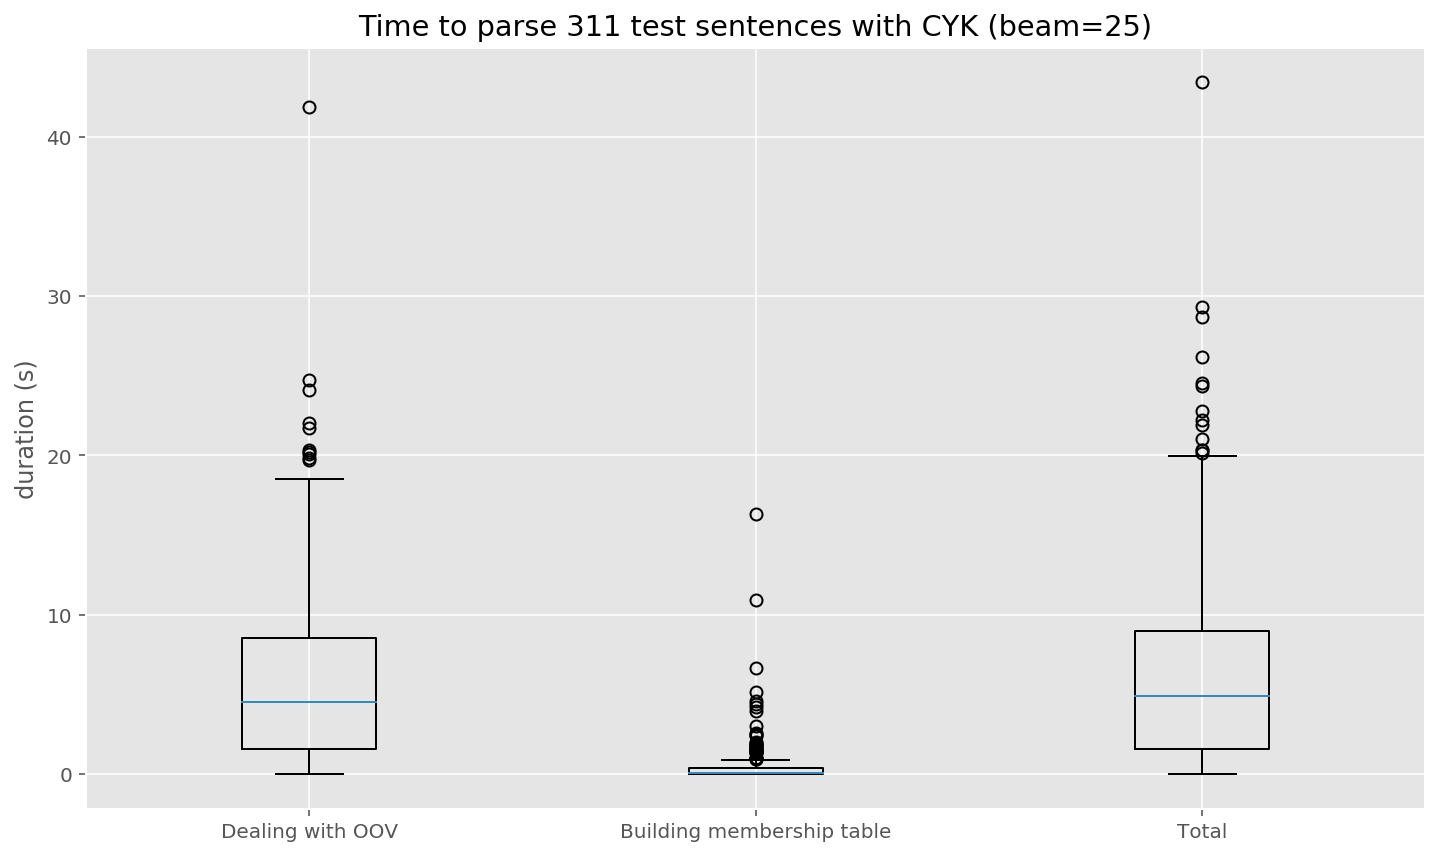